In [49]:
import pandas as pd

# load model
featuresdf = pd.read_pickle('./data_processed/featuresData')
print(featuresdf)


                                               feature class_label
0    [[-677.2284, -675.868, -604.5181, -508.6319, -...        fear
1    [[-541.3354, -500.66827, -471.35553, -459.4574...       happy
2    [[-692.65314, -644.6554, -568.15466, -515.6153...         sad
3    [[-681.12274, -651.9668, -525.6198, -443.5369,...        fear
4    [[-655.34607, -582.11316, -496.3355, -432.5717...       happy
..                                                 ...         ...
595  [[-700.8672, -633.0773, -548.29913, -492.718, ...       happy
596  [[-550.38446, -509.70435, -474.91278, -453.879...         sad
597  [[-533.8698, -473.1169, -420.50345, -391.5591,...        fear
598  [[-667.7516, -631.7557, -551.61646, -502.2961,...       happy
599  [[-761.32166, -732.29486, -638.62305, -572.652...         sad

[600 rows x 2 columns]


In [50]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np


# pick features and classes
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# codify classes in [[0,1,0,0..,0], ..., [0,0,1,0..,0]]
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.4, random_state = 17)

# confirm shape of data's
print("size of x_train: ", x_train.shape)
print("size of x_test: ", x_test.shape)
print("\nsize of y_train: ", y_train.shape)
print("size of y_test: ", y_test.shape)

size of x_train:  (360, 40, 174)
size of x_test:  (240, 40, 174)

size of y_train:  (360, 3)
size of y_test:  (240, 3)


In [51]:
# CNN IMPLEMENTATION (sklearn and keras)

# sequential model with 3 Conv2D and 1 dense layer as final
# convolution layers will detect features based on window slice (filters and multiplex matrix)
# the result will be stored in features map

# if kernel_size or window_size is 2, it results in a 2x2 matrix that grows in 16, 32, 64, 128...

# first layer recieves:
# < MFCC'S number, max_pad_len, audio (1 for mono, 2 for stereo)>

# ReLU for activation function

# Dropout defines the learning speed after each layer

# after each convolutional layer, there's a pooling (MaxPooling2D) layer
# the final layer haves a GlobalAveragePooling2D.
# pooling is used for reduce the input, reducing the training timming
# MaxPooling pick the highest value in window
# Global Average Pooling pick the mean to use in final dense layer

# the final layer has nodes in the same number of types of class
# softmax pick the best probability, set 1 to it and 0 for others

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 


# parameters
num_rows = 40
num_columns = 174
num_channels = 1
filter_size = 2

# reshape the features
x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

# pick number of classes
num_labels = yy.shape[1]

# type of model
model = Sequential()

# convolution layers
model.add(Conv2D(filters=16, kernel_size=filter_size, input_shape=(num_rows, num_columns, num_channels), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

#model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.1))
model.add(GlobalAveragePooling2D())

# final dense layer
model.add(Dense(num_labels, activation='softmax')) 

print("model created!")
print("\npatern: <num_rows, num_columns, num_channels>")
print("input shape: < {} , {} , {} >".format(num_rows, num_columns, num_channels))
print("\nfilter size:", filter_size)

model created!

patern: <num_rows, num_columns, num_channels>
input shape: < 40 , 174 , 1 >

filter size: 2


In [52]:
# COMPILING THE MODEL

# loss function: categorical_crossentropy

#model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop') 
#model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam') 
#model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], optimizer='adam')
#model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'], optimizer='adam') 
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 41, 64)        

In [53]:
# CNN TRAINING

# if input is converging, it's good to set more ephocs

# val_loss starts increasing, val_acc starts decreasing. This means model is cramming values not learning
# val_loss starts increasing, val_acc also increases. This could be case of overfitting or 
#diverse probability values in cases where softmax is being used in output layer
# val_loss starts decreasing, val_acc starts increasing. This is also fine as that means model built is learning 
#and working fine.

# batch_size is god to set as 8, 16 32, 64, 128...
# batch size is the number of samples processed before the model is updated.
# The number of epochs is the number of complete passes through the training dataset.

from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

# number of epochs
num_epochs = 30

# batch_size
# ex: i'm training 1000 samples. if batch_size = 100, the network will train 100 samples, then other 100...
# in the ex, we propagate 10 batches
# if use 1050 samples, you need to get the 50 final and train them (doing 11 batches)
# after each batch, the network updates parameters
# If we used all samples during propagation we would make only 1 update for the network's parameter

# Batch Gradient Descent. Batch Size = Size of Training Set
# Stochastic Gradient Descent. Batch Size = 1
# Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set

num_batch_size = 64

# checkpoint for the model
checkpointer = ModelCheckpoint(filepath='./model_saved/checkpoints/{}_{}.hdf5'.format(num_batch_size, num_epochs), 
                               verbose=1, save_best_only=True)

# pick atual time to calculate time of training
start = datetime.now()

# train the model
#model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)
history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
                    validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

# return training time
duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 1.8495 - accuracy: 0.3250
Epoch 00001: val_loss improved from inf to 1.39832, saving model to ./model_saved/checkpoints/64_30.hdf5
6/6 [==============================] - 1s 98ms/step - loss: 1.8495 - accuracy: 0.3250 - val_loss: 1.3983 - val_accuracy: 0.3292
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 1.4009 - accuracy: 0.4111
Epoch 00002: val_loss improved from 1.39832 to 1.06893, saving model to ./model_saved/checkpoints/64_30.hdf5
6/6 [==============================] - 1s 96ms/step - loss: 1.4009 - accuracy: 0.4111 - val_loss: 1.0689 - val_accuracy: 0.3292
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 1.1101 - accuracy: 0.4667
Epoch 00003: val_loss improved from 1.06893 to 0.95508, saving model to ./model_saved/checkpoints/64_30.hdf5
6/6 [==============================] - 1s 89ms/step - loss: 1.1101 - accuracy: 0.4667 - val_loss: 0.9551 - val_accuracy: 0.3792
Epoch 4/30
6/6 [=

Epoch 28/30
6/6 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9778
Epoch 00028: val_loss did not improve from 0.09427
6/6 [==============================] - 1s 87ms/step - loss: 0.1134 - accuracy: 0.9778 - val_loss: 0.1373 - val_accuracy: 0.9792
Epoch 29/30
6/6 [==============================] - ETA: 0s - loss: 0.0897 - accuracy: 0.9778
Epoch 00029: val_loss did not improve from 0.09427
6/6 [==============================] - 1s 93ms/step - loss: 0.0897 - accuracy: 0.9778 - val_loss: 0.1465 - val_accuracy: 0.9792
Epoch 30/30
6/6 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9722
Epoch 00030: val_loss did not improve from 0.09427
6/6 [==============================] - 1s 89ms/step - loss: 0.0861 - accuracy: 0.9722 - val_loss: 0.0970 - val_accuracy: 0.9917
Training completed in time:  0:00:20.902275


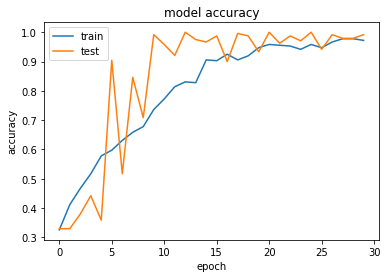

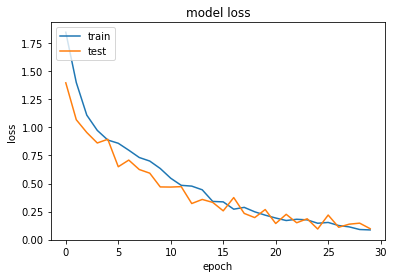

In [54]:
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [55]:
# with keras, is possible to describe a model in JSON format 

# model_from_json (): create a new model based on JSON

from keras.models import model_from_json

model.summary()

# serialize model to JSON
model_json = model.to_json()
with open("./model_saved/model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize model in HDF5
model.save_weights("./model_saved/model.h5")
print("Modelo salvo!")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 41, 64)        